<a href="https://colab.research.google.com/github/williamlidberg/Unet-tutorial/blob/main/U_net_tutorial_with_transfer_learning.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Intro to google colab

# Cells
A notebook is a list of cells. Cells contain either explanatory text or executable code and its output. Click a cell to select it.

## Code cells
Below is a **code cell**. Once the toolbar button indicates CONNECTED, click in the cell to select it and execute the contents in the following ways:

* Click the **Play icon** in the left gutter of the cell;
* Type **Cmd/Ctrl+Enter** to run the cell in place;
* Type **Shift+Enter** to run the cell and move focus to the next cell (adding one if none exists); or
* Type **Alt+Enter** to run the cell and insert a new code cell immediately below it.

There are additional options for running some or all cells in the **Runtime** menu.


In [1]:
a = 10
a

10

# Working with python
Colaboratory is built on top of [Jupyter Notebook](https://jupyter.org/). Below are some examples of convenience functions provided.

In [2]:
import time
print("Sleeping")
time.sleep(30) # sleep for a while; interrupt me!
print("Done Sleeping")

Sleeping


KeyboardInterrupt: ignored

## Adding and moving cells
You can add new cells by using the **+ CODE** and **+ TEXT** buttons that show when you hover between cells. These buttons are also in the toolbar above the notebook where they can be used to add a cell below the currently selected cell.

You can move a cell by selecting it and clicking **Cell Up** or **Cell Down** in the top toolbar.

Consecutive cells can be selected by "lasso selection" by dragging from outside one cell and through the group.  Non-adjacent cells can be selected concurrently by clicking one and then holding down Ctrl while clicking another.  Similarly, using Shift instead of Ctrl will select all intermediate cells.

# Deep learning for cultural remains
In this tutorial you will learn:


1.   Google colab
2.   Import python libraries
3.   Run python code
6.   Build a Unet model
7.   Train and test a Unet model
8.   Transfer learning


## Import data
These two lines downloads a dataset from williams google drive. The first line is long and complicated due to googles shenanigans. The second line unpacks the data into google colabs file tree.

In [5]:
!wget --load-cookies /tmp/cookies.txt "https://docs.google.com/uc?export=download&confirm=$(wget --quiet --save-cookies /tmp/cookies.txt --keep-session-cookies --no-check-certificate 'https://docs.google.com/uc?export=download&id=1EQKhlQFjg0mP7OfoT0NRURQZAgRAqBvj' -O- | sed -rn 's/.*confirm=([0-9A-Za-z_]+).*/\1\n/p')&id=1EQKhlQFjg0mP7OfoT0NRURQZAgRAqBvj" -O /content/earth.zip && rm -rf /tmp/cookies.txt
!unzip /content/earth.zip -d /content/

--2023-10-02 11:27:24--  https://docs.google.com/uc?export=download&confirm=t&id=1EQKhlQFjg0mP7OfoT0NRURQZAgRAqBvj
Resolving docs.google.com (docs.google.com)... 108.177.120.138, 108.177.120.100, 108.177.120.102, ...
Connecting to docs.google.com (docs.google.com)|108.177.120.138|:443... connected.
HTTP request sent, awaiting response... 303 See Other
Location: https://doc-0s-bc-docs.googleusercontent.com/docs/securesc/ha0ro937gcuc7l7deffksulhg5h7mbp1/lpasj9n9kmm7ee3s0s43p9c2e4tctdn1/1696245975000/06925625010966112337/*/1EQKhlQFjg0mP7OfoT0NRURQZAgRAqBvj?e=download&uuid=f07cf7c5-f494-4962-b3a6-cd8b460d9ac6 [following]
--2023-10-02 11:27:25--  https://doc-0s-bc-docs.googleusercontent.com/docs/securesc/ha0ro937gcuc7l7deffksulhg5h7mbp1/lpasj9n9kmm7ee3s0s43p9c2e4tctdn1/1696245975000/06925625010966112337/*/1EQKhlQFjg0mP7OfoT0NRURQZAgRAqBvj?e=download&uuid=f07cf7c5-f494-4962-b3a6-cd8b460d9ac6
Resolving doc-0s-bc-docs.googleusercontent.com (doc-0s-bc-docs.googleusercontent.com)... 142.251.172.

## Import libraries
Python libraries are like R packages. Before they can be used they need to be imported into the python environment.

In [6]:
import os # For data handling
import glob # For data handling
import numpy as np # For arrays
import keras
import tensorflow.keras.backend as K # For deep learning
import tensorflow as tf # For deep learning
import matplotlib.pyplot as plt # For plotting data
import random # for seeds
random.seed(10) # To increase reproducability

## Inspect data
The first stepp in any data analysis is always to inspect the data. The data in this tutorial is stored as a tensorflow dataset. If you want to get into the details on how to create a training dataset you can check out the github linked to the research paper: https://github.com/williamlidberg/Detection-of-hunting-pits-using-airborne-laser-scanning-and-deep-learning

In [7]:
train_images = tf.data.Dataset.load('/content/earth/train/') # These will be used to train the model
test_images = tf.data.Dataset.load('/content/earth/test/') # These will be used to test the model to get a estimate of the preformance.
train_examples = list(train_images.as_numpy_iterator())
print(len(train_images), 'images will be used to train the model.')
print(len(test_images), 'images will be used to test the model.')

1336 images will be used to train the model.
333 images will be used to test the model.


Plot some examples from the training data to make sure it looks resonable. Hunting pits a tiny feaures and on the limit of what can be seen in this digital elevation model.

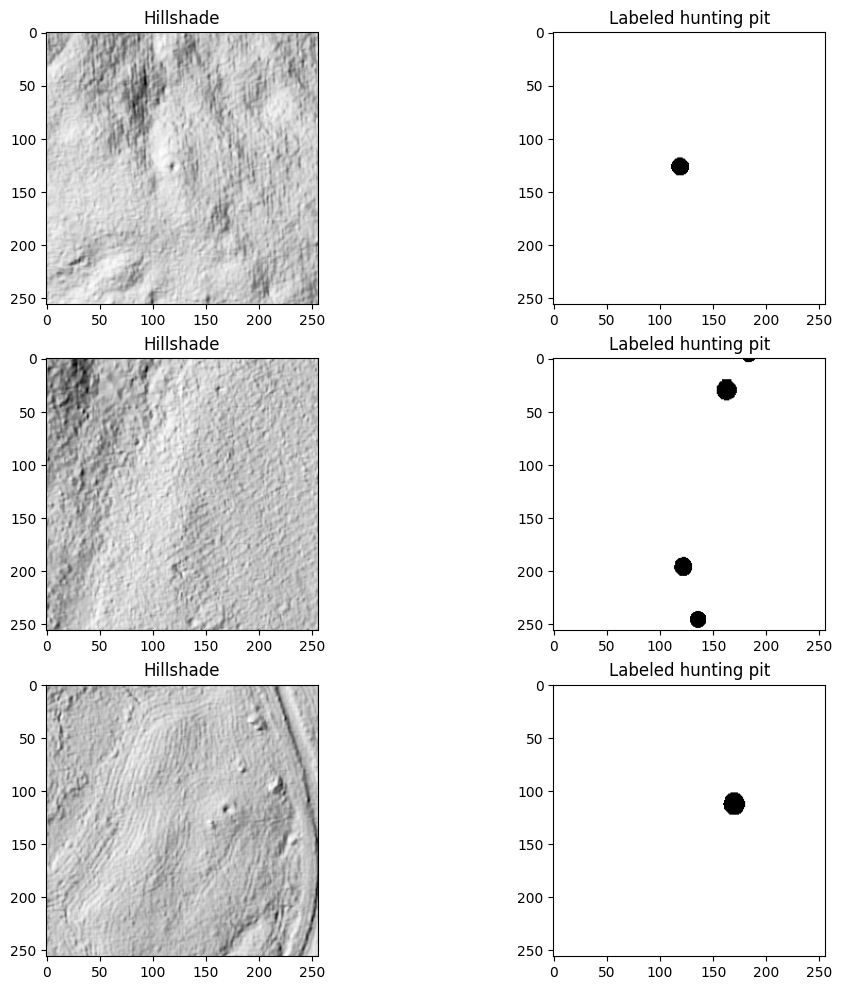

In [8]:
example1 = np.squeeze(train_examples[0]) # image number 0
image1 = example1[0,:,:,]
label1 = example1[1,:,:,]

example2 = np.squeeze(train_examples[42]) # image number 42
image2 = example2[0,:,:,]
label2 = example2[1,:,:,]

example3 = np.squeeze(train_examples[1000])  # image number 1000
image3 = example3[0,:,:,]
label3 = example3[1,:,:,]

# select and plot images
plt.rcParams['figure.figsize'] = [12, 12]
f, axarr = plt.subplots(3,2)
axarr[0,0].set_title('Hillshade')
axarr[0,0].imshow(image1, cmap='Greys_r')
axarr[0,1].set_title('Labeled hunting pit')
axarr[0,1].imshow(label1,cmap='Greys')

axarr[1,0].set_title('Hillshade')
axarr[1,0].imshow(image2, cmap='Greys_r')
axarr[1,1].set_title('Labeled hunting pit')
axarr[1,1].imshow(label2,cmap='Greys')

axarr[2,0].set_title('Hillshade')
axarr[2,0].imshow(image3, cmap='Greys_r')
axarr[2,1].set_title('Labeled hunting pit')
axarr[2,1].imshow(label3,cmap='Greys')

## Build input pipelines
[Batch size](https://medium.com/deep-learning-experiments/effect-of-batch-size-on-neural-net-training-c5ae8516e57) is a term used in machine learning and refers to the number of training examples utilized in one iteration. Larger batch sizes is genreally better but GPU memory usually very limited.

Buffer size is how many images that should be read into system memory (RAM) at the time. For a large number of images it is not possible to read the entire dataset into the system memory but having a small buffer ready speeds up the training process. Otherwise the images needs to be read from disk which is much slower.

**Training pipeline**

In [12]:
BATCH_SIZE = 16
BUFFER_SIZE = 32
train_batches = (train_images
                    .cache() # cache data
                    .shuffle(BUFFER_SIZE) # fill buffer, sample from it and replace with new items (buffer size > training set for perfect shuffling)
                    .batch(BATCH_SIZE)  # set batch size
                    .repeat()  # repeat dataset idefinetely
                    .prefetch(buffer_size=32)) # prefetch 100 images to optimize runtime

**Testing pipeline**

In [13]:
# setup input pipeline
BATCH_SIZE = 16
BUFFER_SIZE = 32
test_batches = (test_images
                    .cache() # cache data
                    .shuffle(BUFFER_SIZE) # fill buffer, sample from it and replace with new items (buffer size > training set for perfect shuffling)
                    .batch(BATCH_SIZE)  # set batch size
                    .repeat(1)  # repeat dataset idefinetely
                    .prefetch(buffer_size=32)) # prefetch 100 images to optimize runtime

## Define metrics to use for evaluation
Accuracy is how many of the pixels are classified correctly by the model. This is not very usefull if most of the landscape consists of one class. In this case most of the forest are not hunting pits.

f1 score is a better option since it tries to take the inbalance of the data into account. f1 = 0 is very low and f1 = 1 is a perfect fit. Both recall and precision are required to calculate F1 score so these have to be defined as well.

In [14]:
def recall_m(y_true, y_pred):
    true_positives = K.sum(K.round(K.clip(y_true * y_pred, 0, 1)))
    possible_positives = K.sum(K.round(K.clip(y_true, 0, 1)))
    recall = true_positives / (possible_positives + K.epsilon())
    return recall

def precision_m(y_true, y_pred):
    true_positives = K.sum(K.round(K.clip(y_true * y_pred, 0, 1)))
    predicted_positives = K.sum(K.round(K.clip(y_pred, 0, 1)))
    precision = true_positives / (predicted_positives + K.epsilon())
    return precision

def f1_m(y_true, y_pred):
    precision = precision_m(y_true, y_pred)
    recall = recall_m(y_true, y_pred)
    return 2*((precision*recall)/(precision+recall+K.epsilon()))

## Build U-net model
[U-net](https://arxiv.org/abs/1505.04597) is a convolutional neural network that was developed for biomedical image segmentation. The network consists of a contracting path and an expansive path, which gives it the [u-shaped architecture](https://lmb.informatik.uni-freiburg.de/people/ronneber/u-net/). The contracting path is a typical convolutional network that consists of repeated application of convolutions, each followed by a rectified linear unit (ReLU) and a max pooling operation. During the contraction, the spatial information is reduced while feature information is increased. The expansive pathway combines the feature and spatial information through a sequence of up-convolutions and concatenations with high-resolution features from the contracting path.

In [16]:
#Build the model
IMG_WIDTH = 256 # image width in number of pixels
IMG_HEIGHT = 256 # image height in number of pixels
IMG_CHANNELS = 1 # a grey scale image only has one band. Normal images (RGB) have three channels.
NUM_CLASSES = 1 # The images are labaled into 0 and 1 where 0 = no hunting pit and 1 = hunting pit

inputs = tf.keras.layers.Input((IMG_HEIGHT, IMG_WIDTH, IMG_CHANNELS))

#Contraction path
c1 = tf.keras.layers.Conv2D(32, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(inputs) # 32 is the number of feature maps and 3, 3 is the size of the convulutional filter.
c1 = tf.keras.layers.Dropout(0.1)(c1) # dropouts combats overfitting
c1 = tf.keras.layers.Conv2D(32, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(c1)
p1 = tf.keras.layers.MaxPooling2D((2, 2))(c1)

c2 = tf.keras.layers.Conv2D(64, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(p1)
c2 = tf.keras.layers.Dropout(0.1)(c2)
c2 = tf.keras.layers.Conv2D(64, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(c2)
p2 = tf.keras.layers.MaxPooling2D((2, 2))(c2)

c3 = tf.keras.layers.Conv2D(128, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(p2)
c3 = tf.keras.layers.Dropout(0.2)(c3)
c3 = tf.keras.layers.Conv2D(128, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(c3)
p3 = tf.keras.layers.MaxPooling2D((2, 2))(c3)

c4 = tf.keras.layers.Conv2D(256, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(p3)
c4 = tf.keras.layers.Dropout(0.2)(c4)
c4 = tf.keras.layers.Conv2D(256, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(c4)
p4 = tf.keras.layers.MaxPooling2D(pool_size=(2, 2))(c4)

c5 = tf.keras.layers.Conv2D(512, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(p4)
c5 = tf.keras.layers.Dropout(0.3)(c5)
c5 = tf.keras.layers.Conv2D(512, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(c5)

#Expansive path
u6 = tf.keras.layers.Conv2DTranspose(256, (2, 2), strides=(2, 2), padding='same')(c5)
u6 = tf.keras.layers.concatenate([u6, c4])
c6 = tf.keras.layers.Conv2D(256, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(u6)
c6 = tf.keras.layers.Dropout(0.2)(c6)
c6 = tf.keras.layers.Conv2D(256, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(c6)

u7 = tf.keras.layers.Conv2DTranspose(128, (2, 2), strides=(2, 2), padding='same')(c6)
u7 = tf.keras.layers.concatenate([u7, c3])
c7 = tf.keras.layers.Conv2D(128, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(u7)
c7 = tf.keras.layers.Dropout(0.2)(c7)
c7 = tf.keras.layers.Conv2D(128, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(c7)

u8 = tf.keras.layers.Conv2DTranspose(64, (2, 2), strides=(2, 2), padding='same')(c7)
u8 = tf.keras.layers.concatenate([u8, c2])
c8 = tf.keras.layers.Conv2D(64, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(u8)
c8 = tf.keras.layers.Dropout(0.1)(c8)
c8 = tf.keras.layers.Conv2D(64, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(c8)

u9 = tf.keras.layers.Conv2DTranspose(32, (2, 2), strides=(2, 2), padding='same')(c8)
u9 = tf.keras.layers.concatenate([u9, c1], axis=3)
c9 = tf.keras.layers.Conv2D(32, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(u9)
c9 = tf.keras.layers.Dropout(0.1)(c9)
c9 = tf.keras.layers.Conv2D(32, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(c9)

outputs = tf.keras.layers.Conv2D(NUM_CLASSES, (1, 1))(c9)

model = tf.keras.Model(inputs=[inputs], outputs=[outputs])


We can also print out a text summary of the model. Note that the first and last layers are both 256x256 just like our resized data. The 1 in the first layer represents the number of channels. A RGB image would have 3 channels but since this is a greyscale it only has 1.

In [18]:
model.summary()

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_1 (InputLayer)        [(None, 256, 256, 1)]        0         []                            
                                                                                                  
 conv2d (Conv2D)             (None, 256, 256, 32)         320       ['input_1[0][0]']             
                                                                                                  
 dropout (Dropout)           (None, 256, 256, 32)         0         ['conv2d[0][0]']              
                                                                                                  
 conv2d_1 (Conv2D)           (None, 256, 256, 32)         9248      ['dropout[0][0]']             
                                                                                              

## Train the U-net
Now we are ready to train the UNet. Epoch is one pass of the model across the training data. Training the model for more epochs takes longer time but gives more accurate results.

The “steps per epoch” parameter is a value that defines the total number of steps taken before one epoch is finished and the next epoch starts during training. It is typically set to the total number of samples in your dataset divided by the batch size. 10 epochs takes around 5min to train on Colabs standard GPU.

In [21]:
steps = len(train_images)/BATCH_SIZE # len means number of images in the training data. Batch size was defined above.
model.compile(tf.keras.optimizers.Adam(learning_rate=0.001), loss=tf.keras.losses.BinaryFocalCrossentropy(gamma=2.0, from_logits=True), metrics=['acc', f1_m, recall_m])
result = model.fit(train_batches, epochs=10, steps_per_epoch=steps)

Epoch 1/10


KeyboardInterrupt: ignored

## Plot the training history

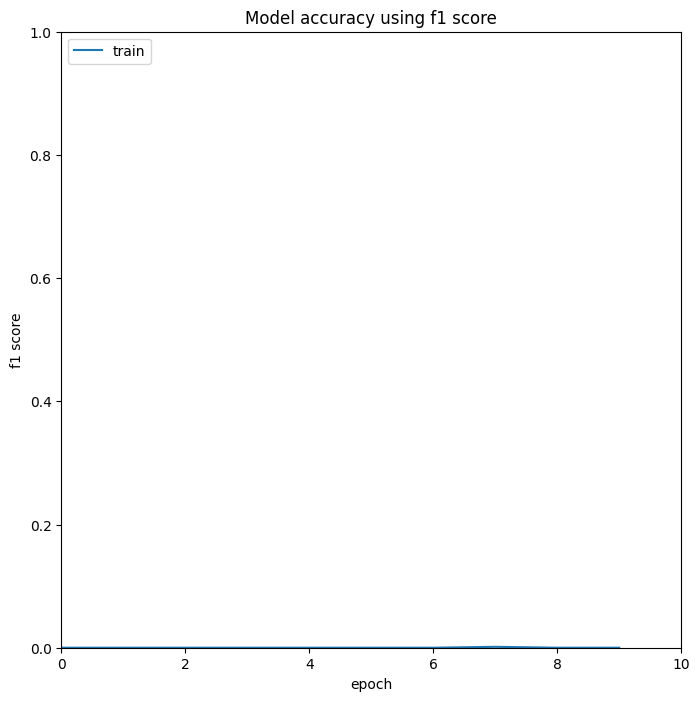

In [22]:
# summarize history for accuracy
plt.rcParams['figure.figsize'] = [8, 8]
plt.plot(result.history['f1_m'])
plt.title('Model accuracy using f1 score')
plt.ylabel('f1 score')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.xlim(0,10)
plt.ylim(0,1)
plt.show()


## Evaluate the model by applying it to the test images

In [23]:
results = model.evaluate(test_batches)

21/21 [==============================] - 5s 201ms/step - loss: 0.0105 - acc: 0.9945 - f1_m: 0.0000e+00 - recall_m: 0.0000e+00


The model seems to strugle to learn how to detect hunting pits. Probably due to a combination of a low number of training images and the fact that hunting pits are very small.

1/1 [==============================] - 1s 1s/step


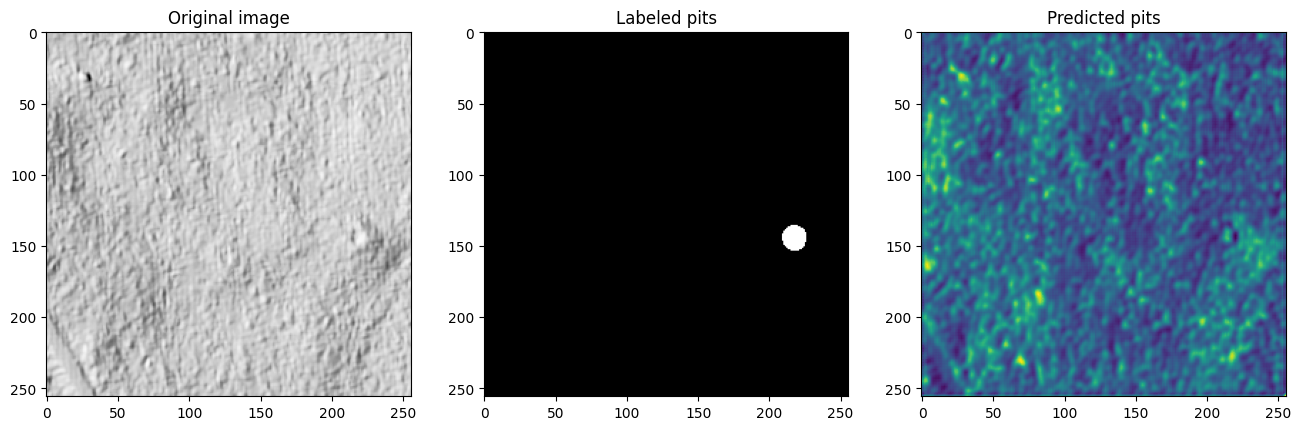

In [24]:
plt.rcParams['figure.figsize'] = [16, 16]
f, axarr = plt.subplots(1,3)

test_examples = list(test_images.as_numpy_iterator())
test_example1 = np.squeeze(test_examples[1])
original = test_example1[0,:,:,]
label = test_example1[1,:,:,]

testimage = np.reshape(original,[1,256,256,1])
prediction = model.predict(testimage)
pred = np.squeeze(prediction)

# Image
axarr[0].set_title('Original image')
axarr[0].imshow(original, cmap='Greys_r')

# Label
axarr[1].set_title('Labeled pits')
axarr[1].imshow(label, cmap='Greys_r')

# Prediction
axarr[2].set_title('Predicted pits')
axarr[2].imshow(pred)

We can set pred>0.5 to get a binary prediction just like the label

1/1 [==============================] - 0s 20ms/step


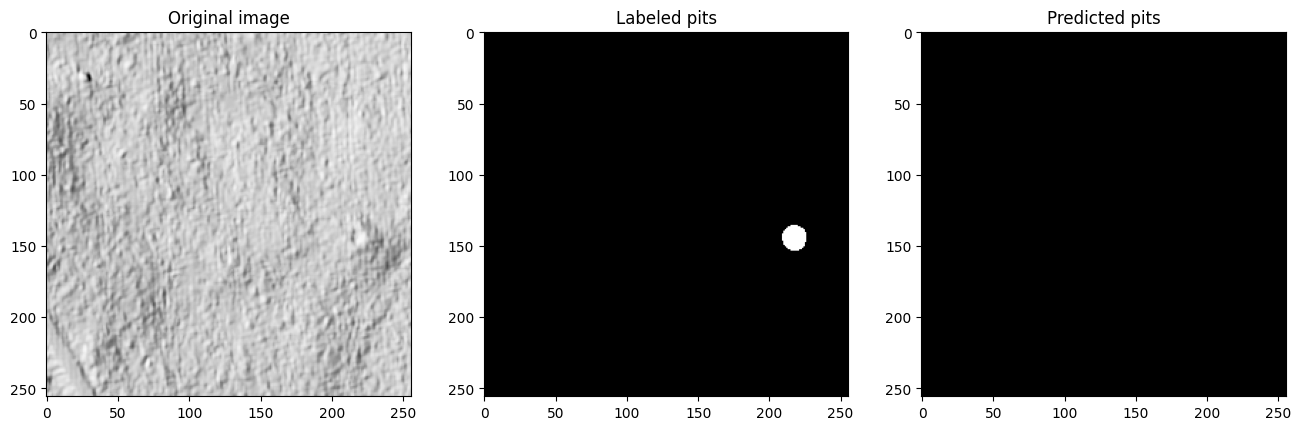

In [25]:
plt.rcParams['figure.figsize'] = [16, 16]
f, axarr = plt.subplots(1,3)

test_examples = list(test_images.as_numpy_iterator())
test_example1 = np.squeeze(test_examples[1])
original = test_example1[0,:,:,]
label = test_example1[1,:,:,]

testimage = np.reshape(original,[1,256,256,1])
prediction = model.predict(testimage)
pred = np.squeeze(prediction)

# Image
axarr[0].set_title('Original image')
axarr[0].imshow(original, cmap='Greys_r')

# Label
axarr[1].set_title('Labeled pits')
axarr[1].imshow(label, cmap='Greys_r')

# Prediction
axarr[2].set_title('Predicted pits')
axarr[2].imshow(pred>0.5, cmap='Greys_r')

# Transfer learning

Transfer learning is a method where a model is first trained on different, but similair, data and then fine-tuned on the real data. This means that the model does not need to start from scratch when training on the real data.

In our case we need a dataset with something similair to hunting pits. Luckley for us there is a place with plenty of pits that we can use. The moon!

NASA has digitized 1.3 milion lunar impact craters with a diameter with a diameter above 1-2 km. NASA also have a digital elevation model created by the Lunar Orbiter Laser Altimeter with a resolution of 118 m.

Due to limitations in google colab we will not be able to train the lunar model from scratch. However we can pull the trained model used in the article from github.

Start by downloading some lunar data to see if the pre-trained model works on impact craters.

In [29]:
!wget --load-cookies /tmp/cookies.txt "https://docs.google.com/uc?export=download&confirm=$(wget --quiet --save-cookies /tmp/cookies.txt --keep-session-cookies --no-check-certificate 'https://docs.google.com/1gQ7dpNZLlWC5PR_J1MLJtmRpPfAkzNv5' -O- | sed -rn 's/.*confirm=([0-9A-Za-z_]+).*/\1\n/p')&id=1gQ7dpNZLlWC5PR_J1MLJtmRpPfAkzNv5" -O /content/moon.zip && rm -rf /tmp/cookies.txt
!unzip /content/moon.zip -d /content/

--2023-10-02 11:51:33--  https://docs.google.com/uc?export=download&confirm=&id=1gQ7dpNZLlWC5PR_J1MLJtmRpPfAkzNv5
Resolving docs.google.com (docs.google.com)... 108.177.120.102, 108.177.120.100, 108.177.120.113, ...
Connecting to docs.google.com (docs.google.com)|108.177.120.102|:443... connected.
HTTP request sent, awaiting response... 303 See Other
Location: https://doc-08-34-docs.googleusercontent.com/docs/securesc/8fbive495clm6efvs911f4ll7rt563uc/jub97re40ret260eahb226beuldq8t49/1696247475000/06925625010966112337/05481906768019079231Z/1gQ7dpNZLlWC5PR_J1MLJtmRpPfAkzNv5?e=download&uuid=60b95bd1-9a2c-42c6-818e-06d670a1d6e8 [following]
--2023-10-02 11:51:33--  https://doc-08-34-docs.googleusercontent.com/docs/securesc/8fbive495clm6efvs911f4ll7rt563uc/jub97re40ret260eahb226beuldq8t49/1696247475000/06925625010966112337/05481906768019079231Z/1gQ7dpNZLlWC5PR_J1MLJtmRpPfAkzNv5?e=download&uuid=60b95bd1-9a2c-42c6-818e-06d670a1d6e8
Resolving doc-08-34-docs.googleusercontent.com (doc-08-34-docs

## Inspect the lunar data

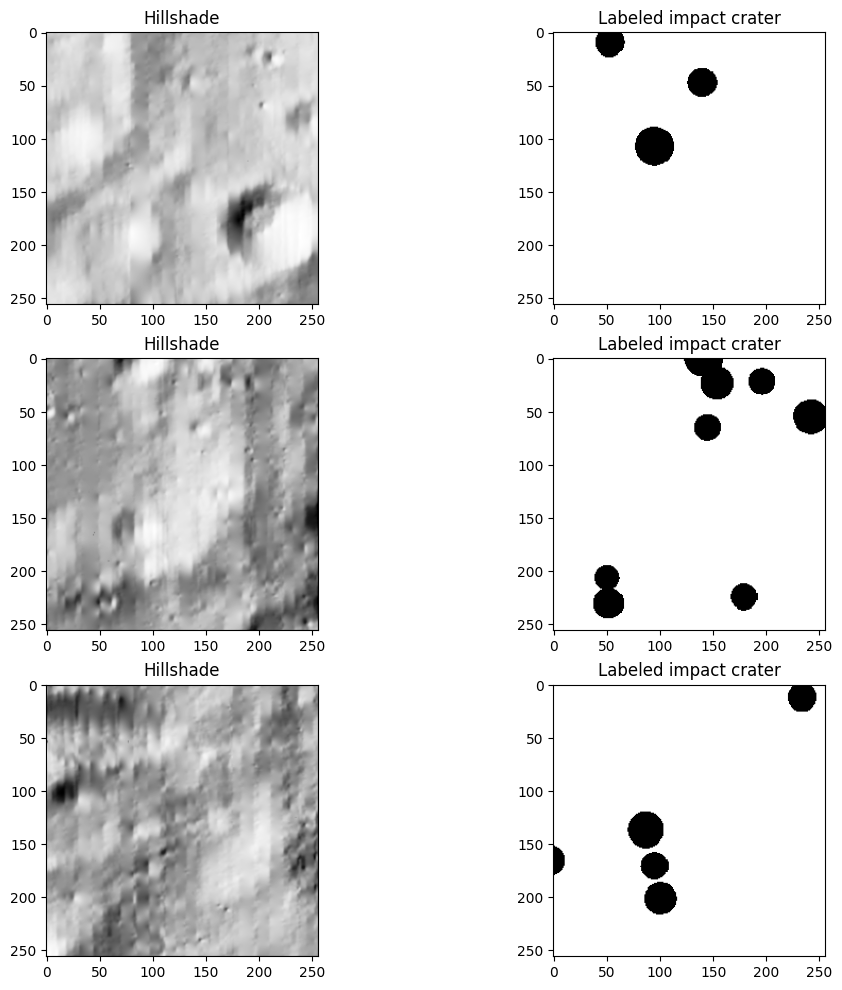

In [30]:
test_images_moon = tf.data.Dataset.load('/content/moon_small/test/') # These will be used to test the model to get a estimate of the preformance.
test_examples_moon = list(test_images_moon.as_numpy_iterator())
example1 = np.squeeze(test_examples_moon[0])
image1 = example1[0,:,:,]
label1 = example1[1,:,:,]

example2 = np.squeeze(test_examples_moon[42])
image2 = example2[0,:,:,]
label2 = example2[1,:,:,]

example3 = np.squeeze(test_examples_moon[70])
image3 = example3[0,:,:,]
label3 = example3[1,:,:,]

# select and plot images
plt.rcParams['figure.figsize'] = [12, 12]
f, axarr = plt.subplots(3,2)
axarr[0,0].set_title('Hillshade')
axarr[0,0].imshow(image1, cmap='Greys_r')
axarr[0,1].set_title('Labeled impact crater')
axarr[0,1].imshow(label1,cmap='Greys')

axarr[1,0].set_title('Hillshade')
axarr[1,0].imshow(image2, cmap='Greys_r')
axarr[1,1].set_title('Labeled impact crater')
axarr[1,1].imshow(label2,cmap='Greys')

axarr[2,0].set_title('Hillshade')
axarr[2,0].imshow(image3, cmap='Greys_r')
axarr[2,1].set_title('Labeled impact crater')
axarr[2,1].imshow(label3,cmap='Greys')

## Download the trained moon model and test it on some impact craters
Start by cloning the github repository where the trained model is stored.

In [31]:
!git clone https://github.com/williamlidberg/Detection-of-hunting-pits-using-airborne-laser-scanning-and-deep-learning.git /content/code/

fatal: destination path '/content/code' already exists and is not an empty directory.


Load the trained model and use it the moon

1/1 [==============================] - 0s 271ms/step


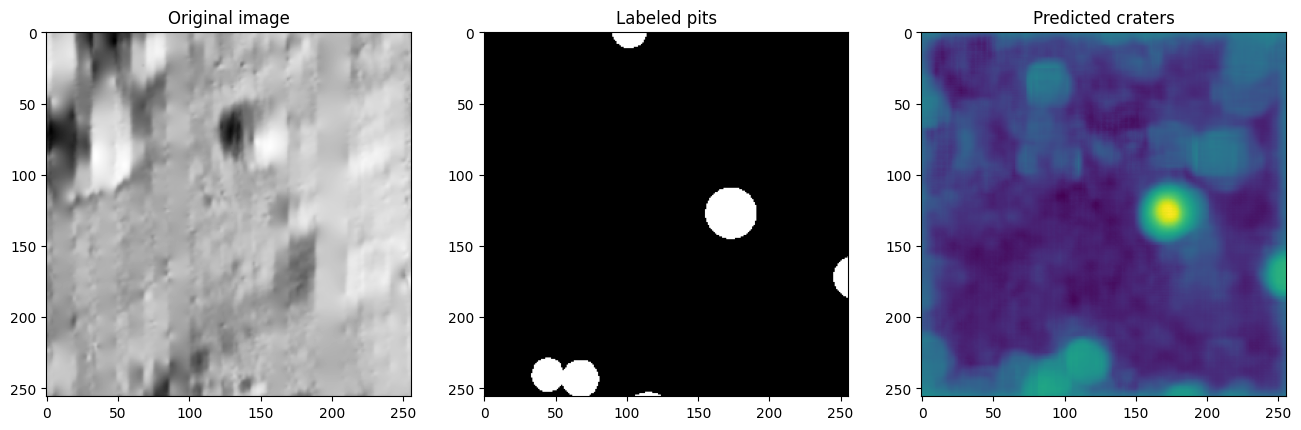

In [32]:
import keras
reconstructed_model = keras.models.load_model('/content/code/models/moon_hillshade.h5') # This is the pre-trained lunar model used in the paper.

plt.rcParams['figure.figsize'] = [16, 16]
f, axarr = plt.subplots(1,3)

test_examples_moon = list(test_images_moon.as_numpy_iterator())
test_example1 = np.squeeze(test_examples_moon[1])
original_moon = test_example1[0,:,:,]
label = test_example1[1,:,:,]

testimage_moon = np.reshape(original_moon,[1,256,256,1])
prediction = reconstructed_model.predict(testimage_moon)
pred = np.squeeze(prediction)

# Image
axarr[0].set_title('Original image')
axarr[0].imshow(original_moon, cmap='Greys_r')

# Label
axarr[1].set_title('Labeled pits')
axarr[1].imshow(label, cmap='Greys_r')

# Prediction
axarr[2].set_title('Predicted craters')
axarr[2].imshow(pred)

# Train the lunar model on data of hunting pits

In [33]:
steps = len(train_images)/BATCH_SIZE
reconstructed_model = keras.models.load_model('/content/code/models/moon_hillshade.h5')
reconstructed_model.compile(tf.keras.optimizers.Adam(learning_rate=0.0001), loss=tf.keras.losses.BinaryFocalCrossentropy(gamma=2.0, from_logits=True), metrics=['acc', f1_m, recall_m])
result_pretrained = reconstructed_model.fit(train_batches, validation_data=test_batches, epochs=10, steps_per_epoch=steps)

Epoch 1/10
83/83 [==============================] - 39s 379ms/step - loss: 0.0056 - acc: 0.9949 - f1_m: 0.1212 - recall_m: 0.0692 - val_loss: 0.0038 - val_acc: 0.9951 - val_f1_m: 0.2200 - val_recall_m: 0.1261
Epoch 2/10
83/83 [==============================] - 33s 392ms/step - loss: 0.0034 - acc: 0.9957 - f1_m: 0.3679 - recall_m: 0.2375 - val_loss: 0.0033 - val_acc: 0.9956 - val_f1_m: 0.3429 - val_recall_m: 0.2123
Epoch 3/10
83/83 [==============================] - 32s 386ms/step - loss: 0.0030 - acc: 0.9960 - f1_m: 0.4401 - recall_m: 0.2965 - val_loss: 0.0031 - val_acc: 0.9958 - val_f1_m: 0.4065 - val_recall_m: 0.2652
Epoch 4/10
83/83 [==============================] - 32s 386ms/step - loss: 0.0027 - acc: 0.9961 - f1_m: 0.4574 - recall_m: 0.3111 - val_loss: 0.0030 - val_acc: 0.9960 - val_f1_m: 0.4486 - val_recall_m: 0.3012
Epoch 5/10
83/83 [==============================] - 32s 384ms/step - loss: 0.0025 - acc: 0.9963 - f1_m: 0.4888 - recall_m: 0.3407 - val_loss: 0.0030 - val_acc: 0.99

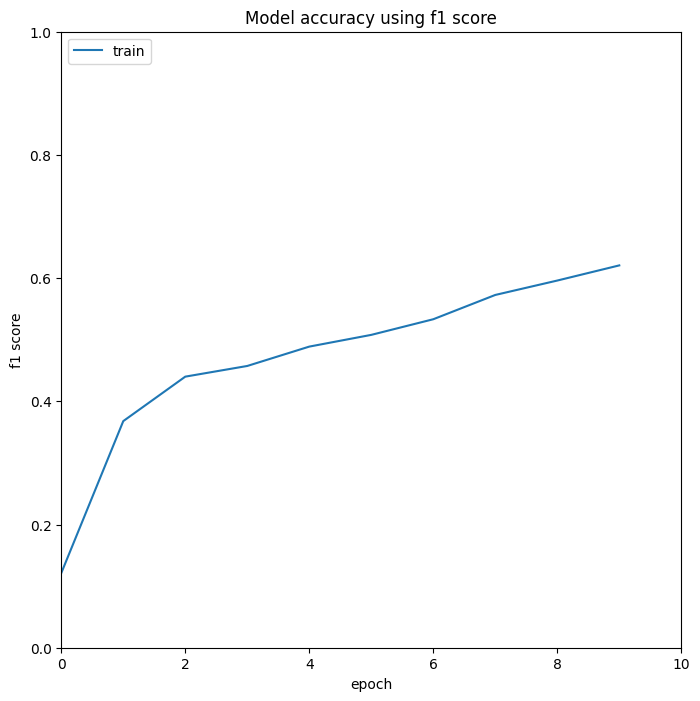

In [34]:
# summarize history for accuracy
plt.rcParams['figure.figsize'] = [8, 8]
plt.plot(result_pretrained.history['f1_m'])
plt.title('Model accuracy using f1 score')
plt.ylabel('f1 score')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.xlim(0,10)
plt.ylim(0,1)
plt.show()

You could train the model for longer and get even better results but at some point the curve will level out. Test the model on the test data and compare the results to the original model.

In [35]:
reconstructed_model.evaluate(test_batches)

21/21 [==============================] - 2s 74ms/step - loss: 0.0036 - acc: 0.9963 - f1_m: 0.5607 - recall_m: 0.4225


[0.0035579476971179247,
 0.9963449239730835,
 0.5606511831283569,
 0.42252668738365173]

Now we can take the new model and try it on a test image.

1/1 [==============================] - 0s 42ms/step


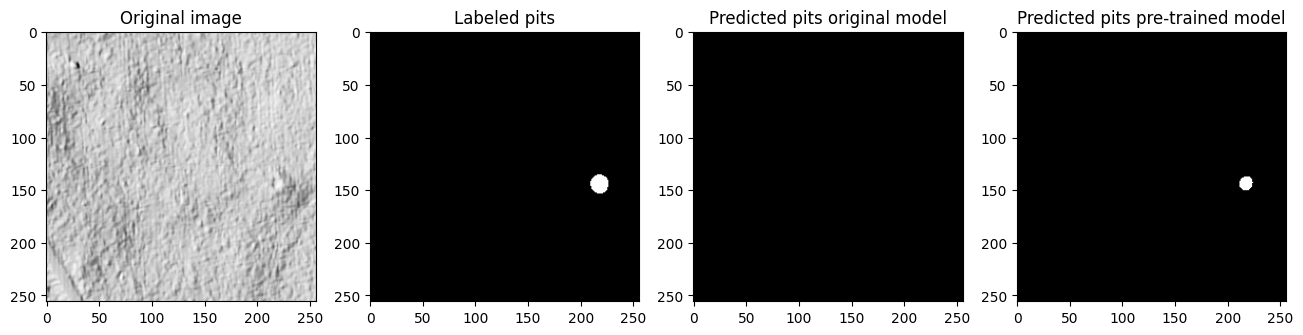

In [37]:
plt.rcParams['figure.figsize'] = [16, 16]
f, axarr = plt.subplots(1,4)

test_examples = list(test_images.as_numpy_iterator())
test_example1 = np.squeeze(test_examples[1])
original = test_example1[0,:,:,]
label = test_example1[1,:,:,]

testimage = np.reshape(original,[1,256,256,1])
# original model
prediction = model.predict(testimage)
pred = np.squeeze(prediction)

#pre trained model
prediction_pretrained = reconstructed_model.predict(testimage)
pred_pretrained = np.squeeze(prediction_pretrained)

# Image
axarr[0].set_title('Original image')
axarr[0].imshow(original, cmap='Greys_r')

# Label
axarr[1].set_title('Labeled pits')
axarr[1].imshow(label, cmap='Greys_r')

# Prediction from original model
axarr[2].set_title('Predicted pits original model')
axarr[2].imshow(pred>0.5, cmap='Greys_r')

# Prediction
axarr[3].set_title('Predicted pits pre-trained model')
axarr[3].imshow(pred_pretrained>0.5, cmap='Greys_r')

## Questions



1.   Will including more images produce better results?
2.   Will an increased batch size improve the model?
3.   Will the model preform better when training for more epochs?
4.   Does training the original model for twice as lone result in the same accuracy as the pre-trained model?





---



---


## Reading

https://arxiv.org/abs/1505.04597

https://towardsdatascience.com/types-of-convolutions-in-deep-learning-717013397f4d

https://naokishibuya.medium.com/up-sampling-with-transposed-convolution-9ae4f2df52d0


## Contact
William.lidberg@slu.se




